## Libraries

As always, we rely on a lot of libraries.

In [2]:
import pandas as pd
import re
import torch
import torch.nn as nn
import numpy as np
import random as rand
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import urllib.request
import numpy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

## Loading Text

We load the text of Harry Potter from a website and preprocess it. In particular, we only want the chapters of the book and we make all words lowercase. Finally, we remove annoying characters like new lines.

In [3]:
url1 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%201%20-%20The%20Philosopher's%20Stone.txt"
url2 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%202%20-%20The%20Chamber%20of%20Secrets.txt"
url3 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%203%20-%20The%20Prisoner%20of%20Azkaban.txt"
url4 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%204%20-%20The%20Goblet%20of%20Fire.txt"
url5 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%205%20-%20The%20Order%20of%20the%20Phoenix.txt"
url6 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%206%20-%20The%20Half%20Blood%20Prince.txt"
url7 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%207%20-%20The%20Deathly%20Hallows.txt"

def read_file(url, start_phrase, end_phrase, remove):
  with urllib.request.urlopen(url) as webpage:
    text = webpage.read().decode("utf8")
    start = text.index(start_phrase)
    text = text[start:]
    end = text.index(end_phrase)
    text = text[:end]
  return text.lower().replace('\n', '').replace('¬','').replace(',','').replace('.','').replace(remove, '')

text1 = read_file(url1, 'THE BOY WHO LIVED', 'Page | 348', 'Harry Potter and the Philosophers Stone - J.K. Rowling')
text2 = read_file(url2, 'THE WORST BIRTHDAY', 'Page | 380', 'Harry Potter and the Chamber of Secrets - J.K. Rowling')
text3 = read_file(url3, 'OWL POST', 'Page | 487', 'Harry Potter and the Prisoner of Azkaban - J.K. Rowling')
text4 = read_file(url4, 'THE RIDDLE HOUSE', 'Page | 811', 'Harry Potter and the Goblet of Fire - J.K. Rowling')
text5 = read_file(url5, 'DUDLEY DEMENTED', 'Page | 1108', 'Harry Potter and the Order of the Phoenix - J.K. Rowling')
text6 = read_file(url6, 'THE OTHER MINISTER', 'Page | 730', 'Harry Potter and the Half Blood Prince - J.K. Rowling')
text7 = read_file(url7, 'THE DARK LORD ASCENDING', 'Page | 856', 'Harry Potter and the Deathly Hallows - J.K. Rowling')

text = text1 + text2 + text3 + text4 + text5 + text6 + text7

In [4]:
len(text)

6370219

## Tokenizing

Now we tokenize the text. That is, we turn the string into a list of words.

In [5]:
def get_frequent(tokens, threshold=20):
  frequency = {token : 0 for token in set(tokens)} #build dictionary with key for every unique word
  for token in tokens:
    frequency[token] += 1 
  
  frequent_tokens = []
  for token in tokens: #iterate through text
    if frequency[token] >= threshold: 
      frequent_tokens += [token] 
  
  return frequent_tokens, len(set(frequent_tokens)) 

In [6]:
letters = 'abcdefghijklmnopqrstuvwxyz' # pre-processing text
def process_word(word): #split based on based
  return ''.join([letter for letter in word if letter in letters]) #join letters
tokens = [process_word(word) for word in text.split(' ')]

tokens, num_tokens = get_frequent(tokens) #get each word as a value in a list
print(tokens[:100]) 

['the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'youd', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didnt', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'of', 'a', 'firm', 'called', 'which', 'made', 'he', 'was', 'a', 'big', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so']


In [7]:
num_tokens

3853

In [8]:
print(f'There are {len(tokens)} total tokens and {num_tokens} unique tokens.')

There are 1093411 total tokens and 3853 unique tokens.


Now we map from each word (token) to a unique index and back. We will use this for the one hot encoding of the word.

In [9]:
def mapping(tokens):
  word_to_id = {}
  id_to_word = {}

  for i, token in enumerate(set(tokens)): #creates correspondence between word and index
    word_to_id[token] = i
    id_to_word[i] = token
  
  return word_to_id, id_to_word

WORD_TO_ID, ID_TO_WORD = mapping(tokens) #global variable
num_tokens = len(set(tokens)) 
print(len(set(tokens)))

3853


The next step is to get the dataset we will use. We do this by iterating through the tokens with a sliding window. For each word $w$, we look at its neighbors $u$ and add a data point $(w,u)$ where we need to predict $u$ on input $w$. For now, we store the data as indices to avoid carrying around a bunch of zeros in the one hot encoding.

In [10]:

def process(tokens, window=2, threshold=100): #window is proximity
  X = np.empty((num_tokens,num_tokens))#initialize two lists for 2-gram
  for i in range(len(tokens)-1):
    index_i = WORD_TO_ID[tokens[i]] 
    for j in list(range(max(0,i-window), min(len(tokens), i+window+1))): #range for tokens with window
        index_j = WORD_TO_ID[tokens[j]] 
        X[index_i][index_j] += 1
  return X


# Initialization

Now we define the custom class we need so we can wrap the nice DataLoader function around our dataset.

In [11]:
# class GloVe(nn.Module): #single matrix
#   def __init__(self, num_tokens): 
#     super(GloVe, self).__init__() #inherit from other class





In [12]:
# def one_hot(word, num_tokens):
#   vector = np.zeros(num_tokens)
#   vector[WORD_TO_ID[word]] += 1
#   return vector

In [16]:
# def loss(model, X, num_tokens, one_hot):
#   loss = 0
#   for i in range(num_tokens):
#     for j in range(num_tokens):

#       if X[i][j].item() > 0.0:
#           vec_i = torch.Tensor(one_hot(list(set(tokens))[i], num_tokens))
#           vec_j = torch.Tensor(one_hot(list(set(tokens))[j], num_tokens))

#           first = (model.U[vec_i].T @ model.V[vec_j] + model.b[vec_i] + model.c[vec_j] - np.log(X[i][j]))**2
#           second = 0 if X[i][j] < 100 else 1
#           loss += first*second
    
#   return loss/2
    
# model = GloVe(num_tokens) #initialize model

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #pass in all model parameters

def helper_check(n):
  if(n < 100):
    return (n/100)**.75
  else:
    return 1
  
def loss_GloVe(X, U, V, b, c):
  UV = np.matmul(U,V)
  loss = (helper_check(X))*(UV + b + c - np.log(X))**2
  return loss


In [19]:
def gradient_comp(X,U,V,b,c):
  lr = .002
  UV = np.matmul(U,V)
  cost = (lr)*(2)*(helper_check(X)) *(UV + b + c - np.log(X))
  new_U = U - cost*V
  new_V = V - cost*U
  new_b = b - cost
  new_c = c - cost
  return new_U, new_V, new_b, new_c

Finally, we're ready to initialize the architecture, loss, and optimizer. Notice the simplicity of the model!

## Training

Now let's train.

In [20]:
# num_epochs = 20
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# for epoch in range(1, num_epochs+1): #for each epoch
#     optimizer.zero_grad()
#     total_loss = model.forward() #put data on device
#     loss = loss(model, X, num_tokens, one_hot)
#     loss.backward() #backward pass
#     optimizer.step() #forward pass
#     print(f'Epoch: {epoch} \t Loss: {losses[-1]}') #print out epoch with loss

U = np.random.rand(num_tokens, 128)
V = np.random.rand(128, num_tokens)
c = np.random.rand(num_tokens)
b = np.random.rand(num_tokens)

losses = []
X = process(tokens)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  loss_total = 0
  m, n = np.nonzero(X)
  for i,j in zip(m,n):
    loss = loss_GloVe(X[i][j], U[i], V[:,j], b[i], c[j])
    U[i], V[:,j], b[i], c[j] = gradient_comp(X[i][j], U[i], V[:,j], b[i], c[j])
    loss_total += loss
  losses += [loss_total/num_tokens]
  print(f'Epoch: {epoch} \t Loss: {loss}')


Epoch: 1 	 Loss: 80.62909044754548
Epoch: 2 	 Loss: 0.9229396877969317
Epoch: 3 	 Loss: 3.8719088339799397
Epoch: 4 	 Loss: 10.325589301966788
Epoch: 5 	 Loss: 13.939778878969825
Epoch: 6 	 Loss: 15.207340893775466
Epoch: 7 	 Loss: 15.070775177385492
Epoch: 8 	 Loss: 14.197146884378803
Epoch: 9 	 Loss: 12.991583722633777
Epoch: 10 	 Loss: 11.68494192092195
Epoch: 11 	 Loss: 10.401866277165698
Epoch: 12 	 Loss: 9.204578161137126
Epoch: 13 	 Loss: 8.11955269910307
Epoch: 14 	 Loss: 7.153422869936215
Epoch: 15 	 Loss: 6.302333076846985


## Exploring the Embeddings

What is the next word predicted?

In [32]:
# target = torch.tensor([WORD_TO_ID['quidditch']]).to(DEVICE)
# candidates = torch.tensor(list(ID_TO_WORD.keys())).to(DEVICE) #all different IDs and put on device so runs quickly
# candidates_embedded = model(candidates) #apply model
# target_embedded = model(target) 

# similarities = candidates_embedded @ target_embedded.T #compute similarities between two
# _, indices = torch.topk(similarities.squeeze(), 10) #

# for index in indices:
#   print(ID_TO_WORD[index.item()]) #convert ID back to word and print out

# #print out all words similar to quidditch


target = [WORD_TO_ID['quidditch']]
candidates = list(ID_TO_WORD.keys())
candidates_embedded = []
for j in range(len(candidates)):
  candidates_embedded.append(V[:,j])
target_embedded = V[:, target]
similarities = candidates_embedded @ target_embedded
#https://www.geeksforgeeks.org/python-indices-of-n-largest-elements-in-list/
result = sorted(range(len(similarities)), key = lambda sub: similarities[sub])[-10:]
results = []
for i in range(10):
  results.append(ID_TO_WORD[result[i]])
print(results)


['moonlight', 'sneering', 'lift', 'complain', 'heres', 'fluffy', 'wiping', 'hurriedly', 'mustnt', 'quidditch']


To investigate the model, let's visualize the embeddings of the words.

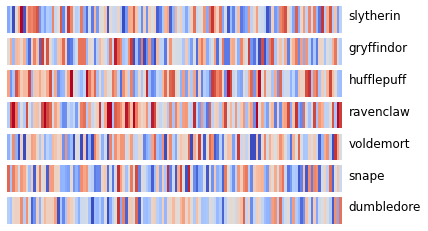

In [33]:
def embed(word):
  w = WORD_TO_ID[word]
  return V[:,w]

words = ['slytherin', 'gryffindor', 'hufflepuff', 'ravenclaw',
         'voldemort', 'snape', 'dumbledore']
embeddings = [embed(word) for word in words] 
num_embed = len(embeddings)
cmap = matplotlib.cm.coolwarm
fig, axes = plt.subplots(num_embed, 1)
norm = matplotlib.colors.Normalize(vmin=embeddings[0].min(), vmax=embeddings[0].max())
for idx in range(num_embed):
  ax = axes[idx]
  embedding = embeddings[idx]
  for i in range(128):
    ax.add_patch(Rectangle((i/128, 0),.05,1, color=cmap(norm(embedding[i]))))
  ax.text(1.02, .5, words[idx], fontsize=12)
  ax.axis('off')
plt.show()